<a href="https://colab.research.google.com/github/AdamHopkinss/DD2365/blob/main/Lab2%20Unsteady%20Flow/Mandatory_assigment_Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

Adam Hopkins Lab 2: Unsteady Flow

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

The Flow fields remain stable (laminar) for Reynolds number 1 and 10, while a Reynolds number of 100 and 1000 yielded unstable, or turbulent flow.

It was verified that when a von Karman vortex street was observed, the Strouhal number was around 0.2.

For low mesh resolutions, the high frequencies, or fast changes in the fields, could not be captured, which was reflected in the Strouhal number, drag- and lift-coefficient plots. But when the mesh reached a resolution of h=1/32, these high frequencies could be captured.

# **About the code**

In [ ]:
# This program is an example file for the course
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden.

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

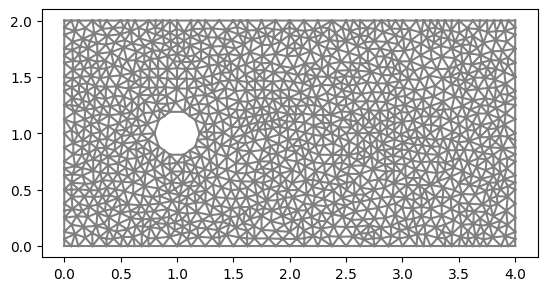

In [ ]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

To base the simulations on the Reynolds number, define $u_{in}$ (inflow velocity) based on the Reynolds nmumber.


In [ ]:
# Define the Dynamic viscosity based on the Reynolds number
rho = 1                   # Density = 1, water
uin = 1                   # Inflow velocity
Re = 100               # Reynolds number         Change this constant to study the flow
D = 2*rc                # Characteristic length (here it's the diameter of the circle)
mu = rho * uin * D / Re

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = uin
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [ ]:
# Set viscosity
nu = mu / rho   # change where this is defined, so that the Reynolds number define uin

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Triple decomposition**

In [ ]:
import scipy.linalg.lapack as la
import numpy as np

def triple_decomposition(grad_u):
    new_grad = np.array([[0,0,0],
                         [0,0,0],
                         [0,0,0]])
    for i in range(2):
      for j in range(2):
        new_grad[i,j] = grad_u[i,j]
    def dselect(arg1,arg2): return (arg2==0)
    T = la.dgees(dselect,new_grad,sort_t = 1)[0]
    sh = np.linalg.norm([T[0,1],T[0,2],T[1,2]+T[2,1]])
    el = np.linalg.norm(np.diag(T))
    rr = np.sqrt(2*min(abs(T[1,2]),abs(T[2,1]))**2)
    return sh, el, rr

**Compute force on boundary**

In [ ]:
# Compute the Lift and Drag Forces, need both to calculate the Lift and Drag coefficients
# Compute Lift Force:
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0     # Lift force is verticle.

psi_lift_expr = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_lift = interpolate(psi_lift_expr, V)

Force_lift = inner((u1 - u0)/dt + grad(um1)*um1, psi_lift)*dx - p1*div(psi_lift)*dx + nu*inner(grad(um1), grad(psi_lift))*dx

# Compute Drag Force:
# Define the direction of the force to be computed
phi_x = 1.0
phi_y = 0.0     # Drag force is horizontal.

psi_drag_expr = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_drag = interpolate(psi_drag_expr, V)

Force_drag = inner((u1 - u0)/dt + grad(um1)*um1, psi_drag)*dx - p1*div(psi_drag)*dx + nu*inner(grad(um1), grad(psi_drag))*dx



#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
# psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
# psi = interpolate(psi_expression, V)

# Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = D   # D = 2*rc, computed above
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Set file save frequency
para_time = 0
para_freq = 60

# Force computation data
force_array_lift = np.array(0.0)
force_array_lift = np.delete(force_array_lift, 0)
force_array_drag = np.array(0.0)
force_array_drag = np.delete(force_array_drag, 0)

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.03285506167650246


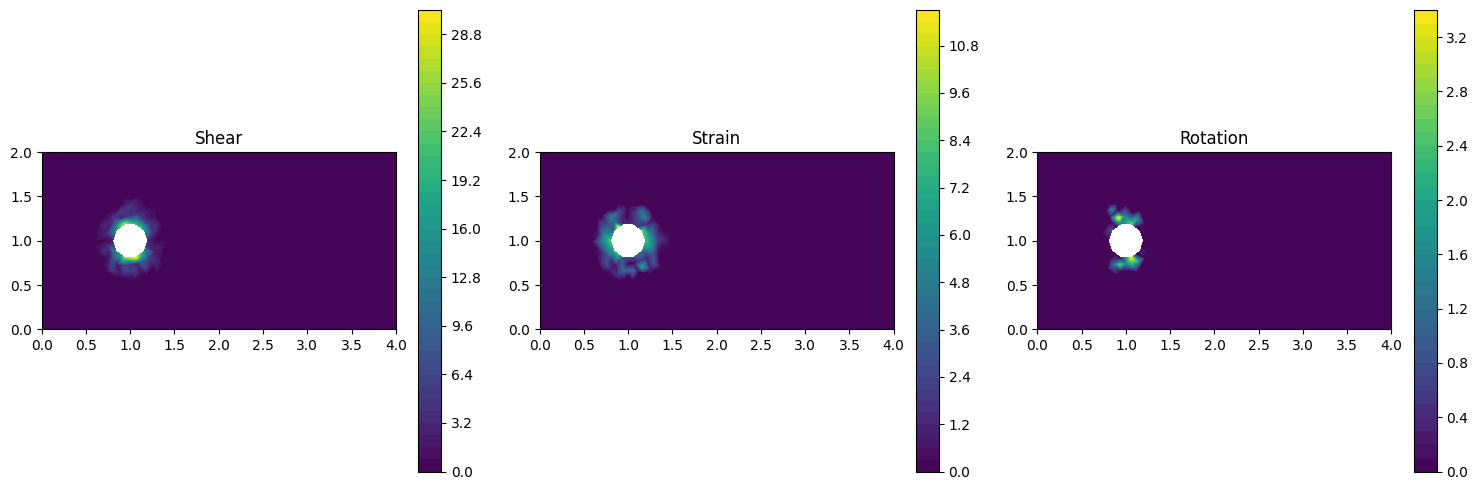

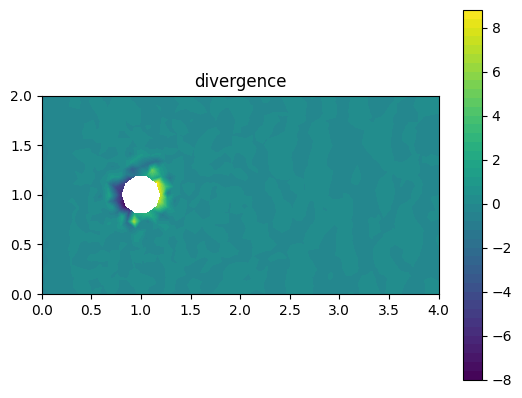

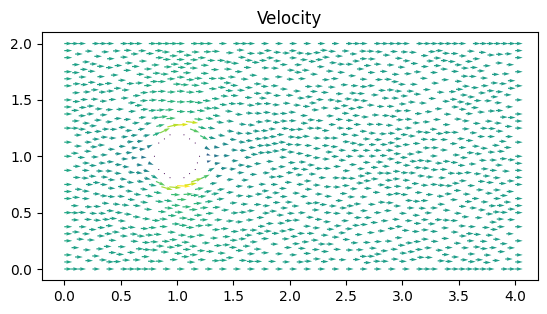

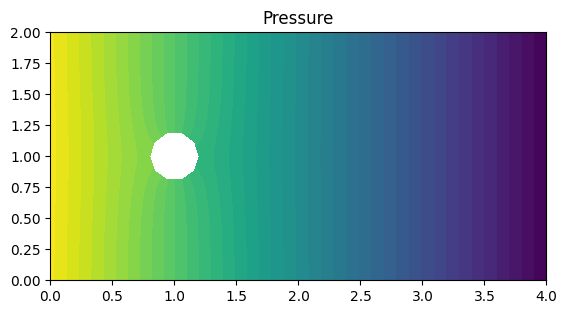

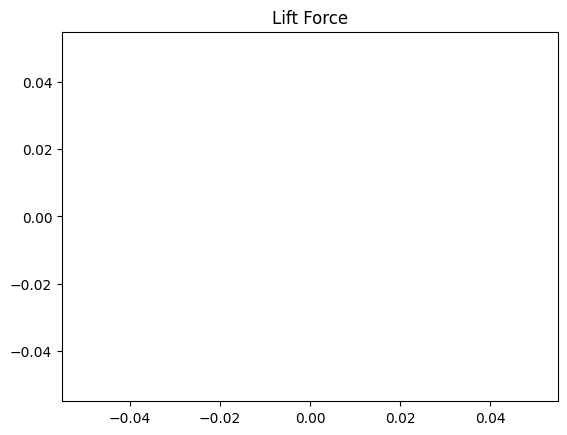

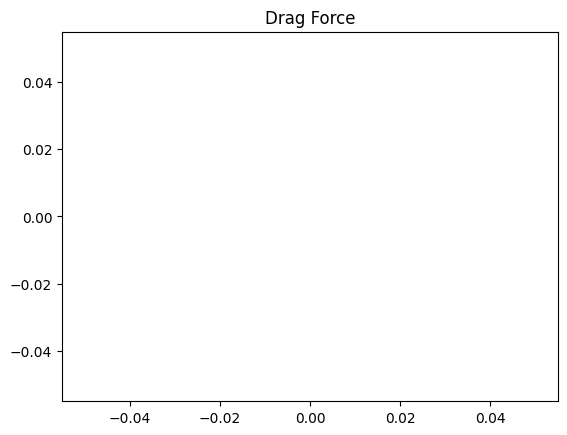

Time t = 3.022665674238231


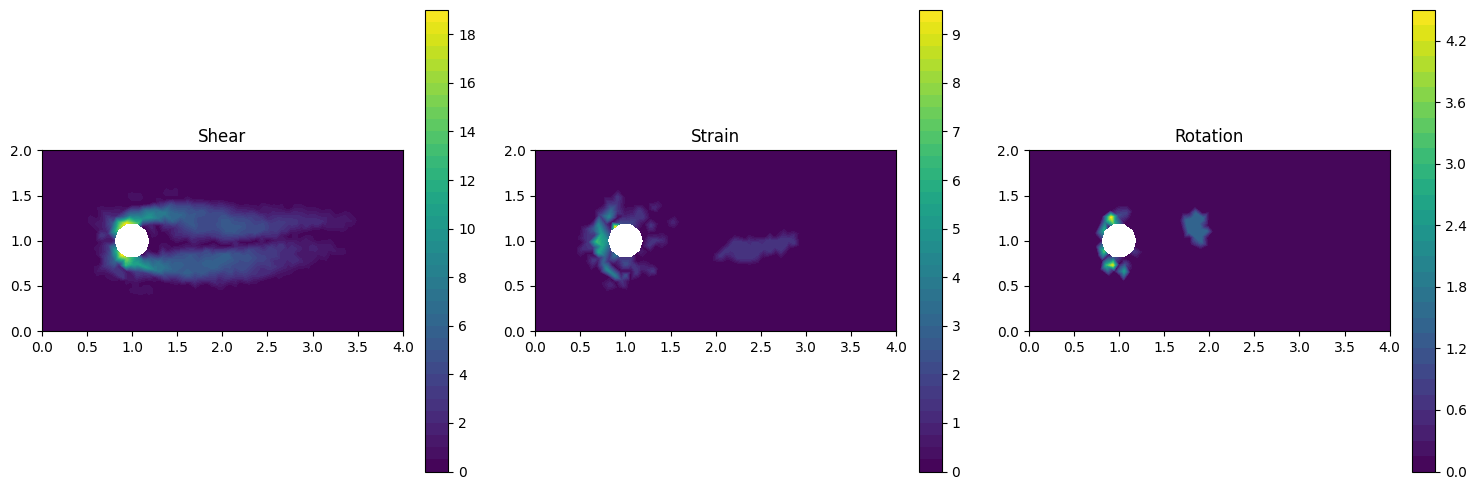

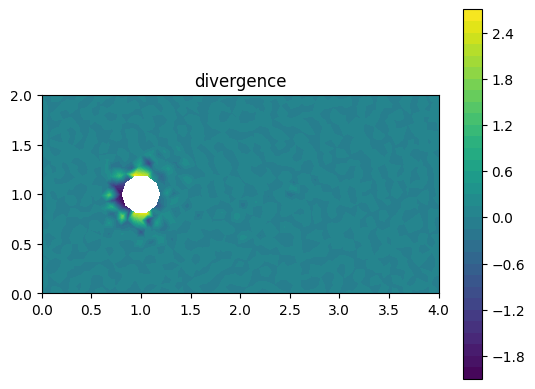

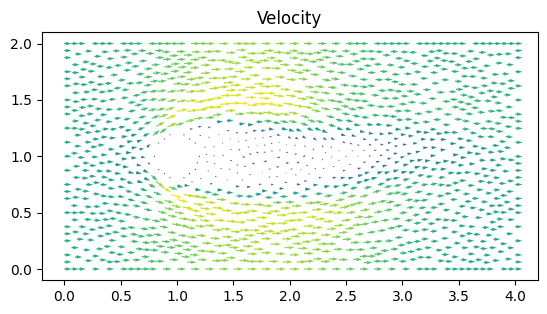

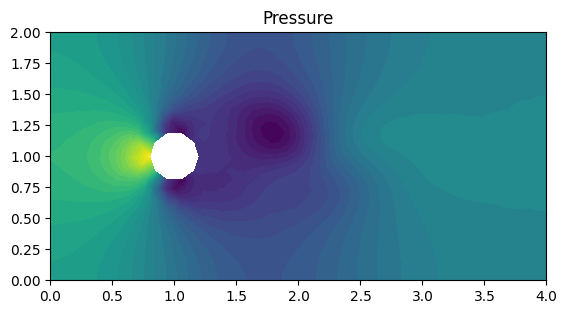

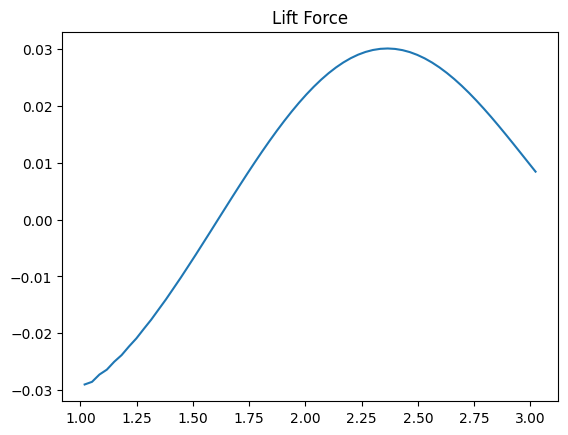

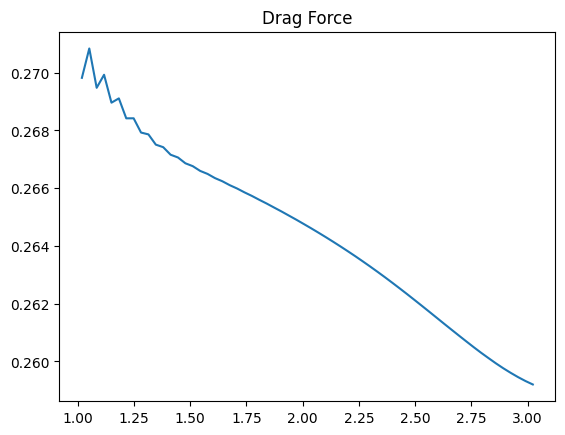

Time t = 6.012476286799972


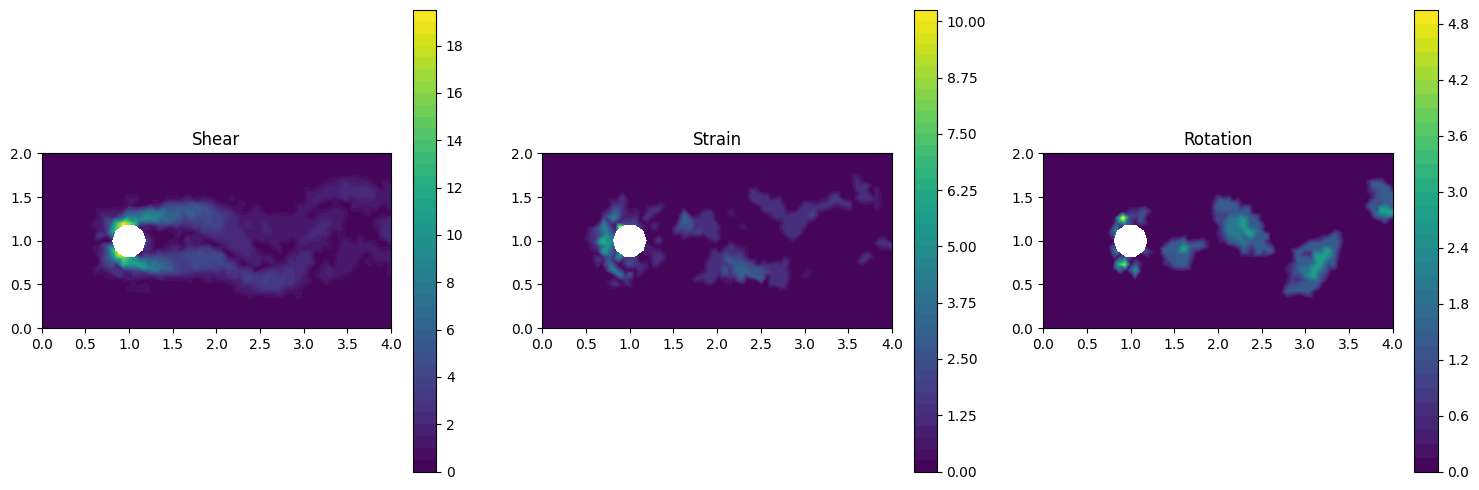

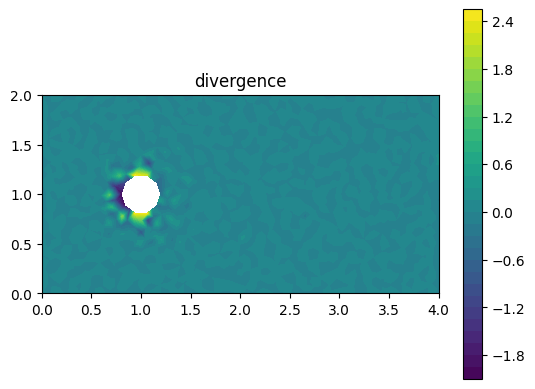

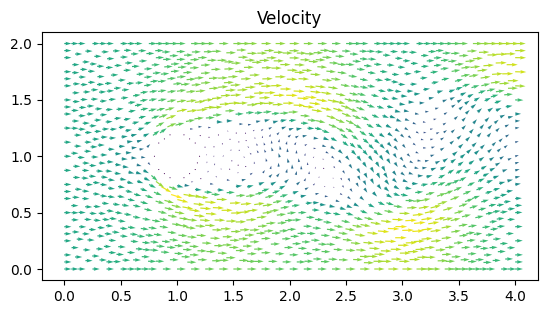

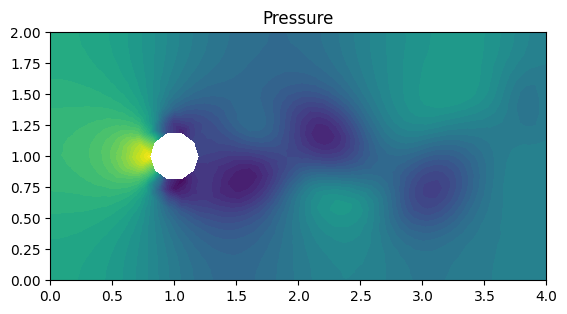

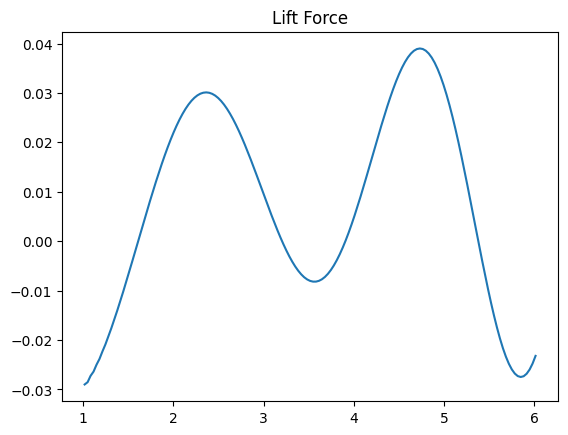

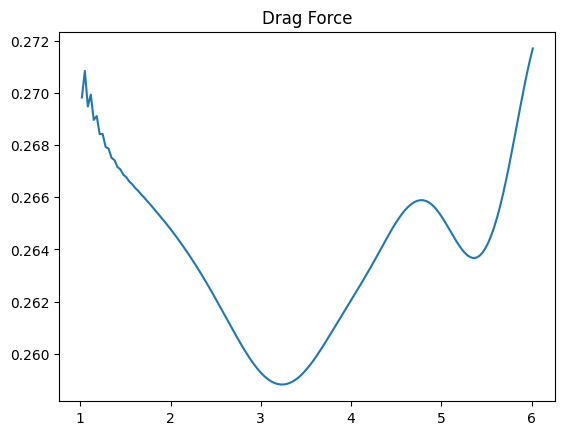

Time t = 9.002286899361685


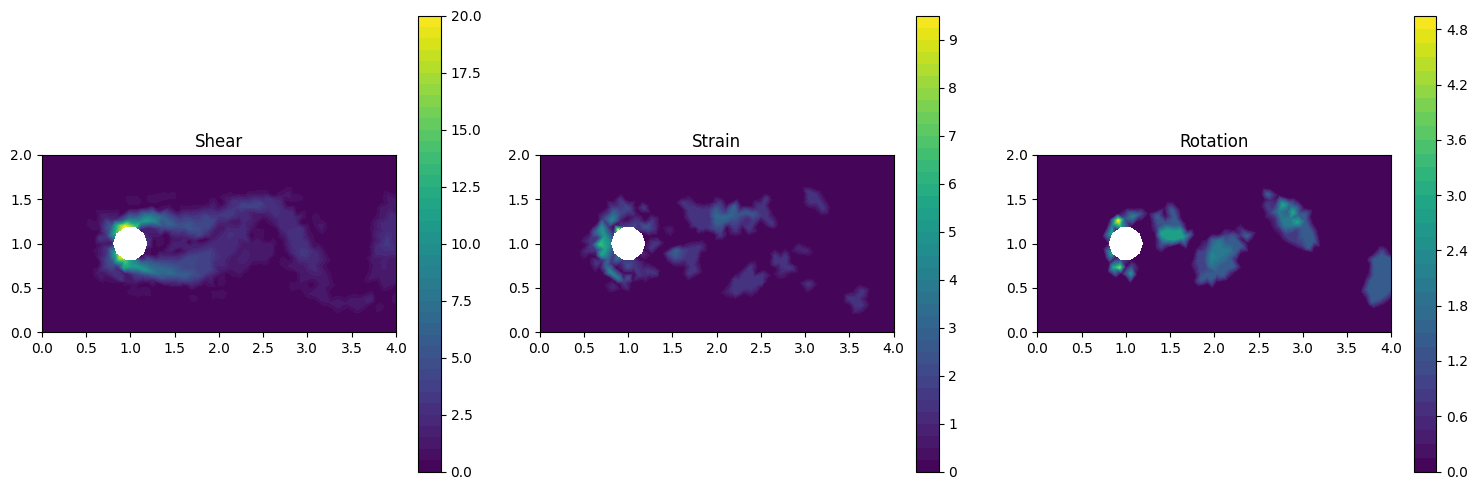

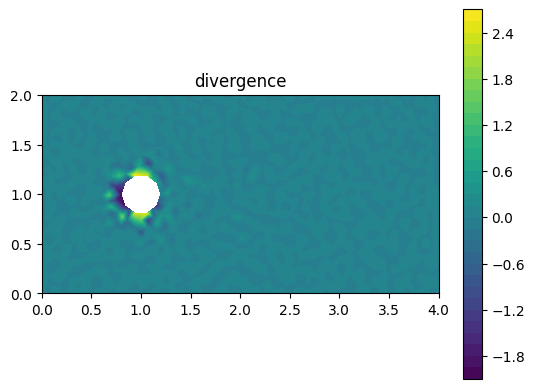

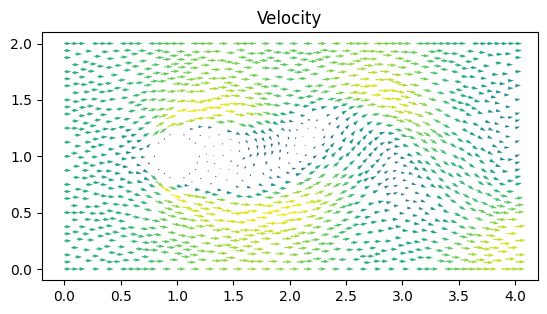

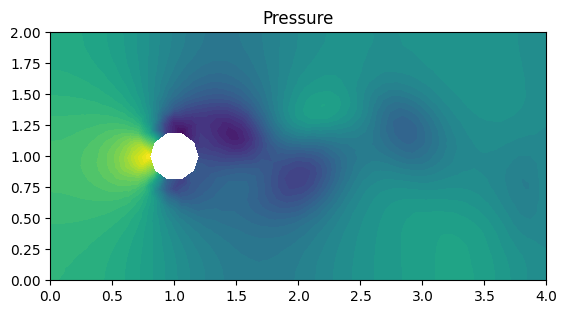

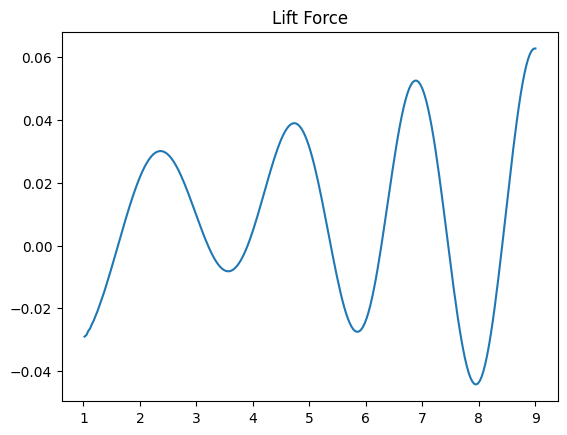

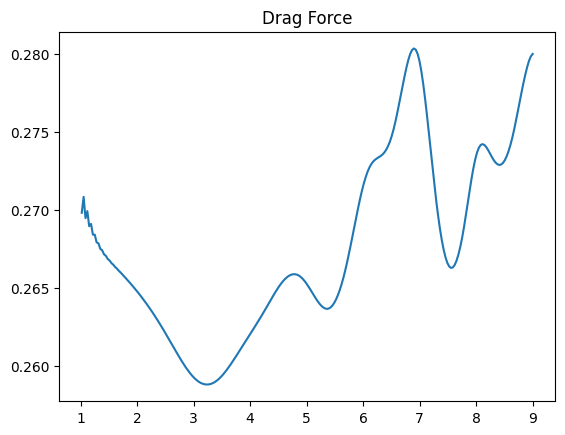

Time t = 12.024952573599847


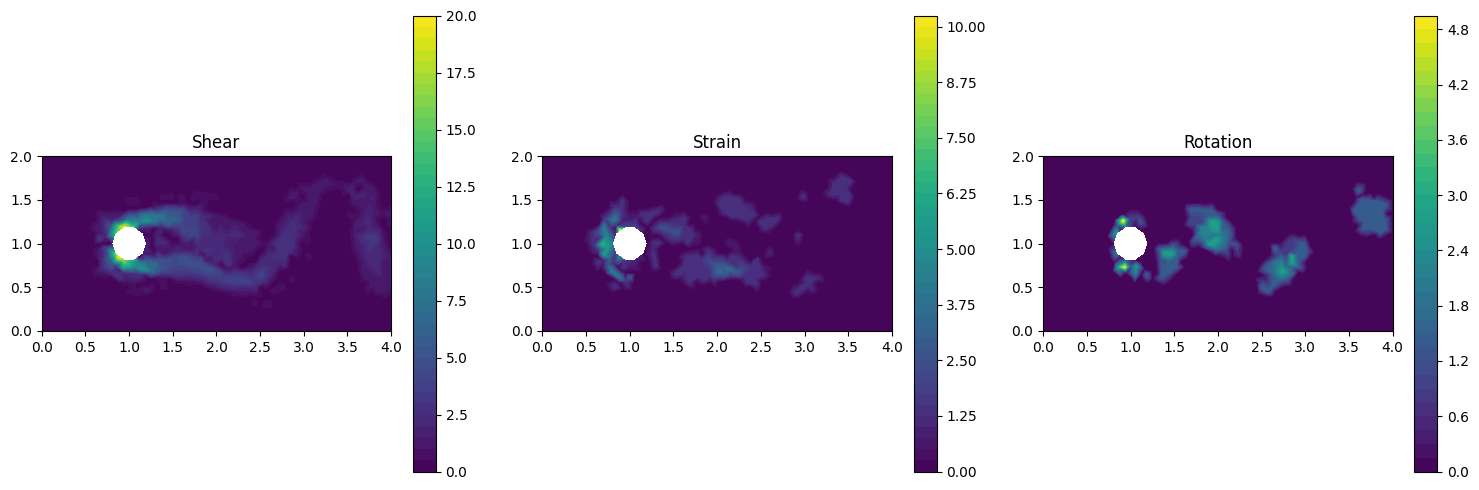

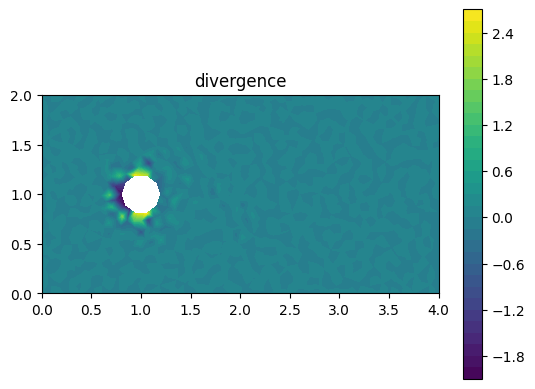

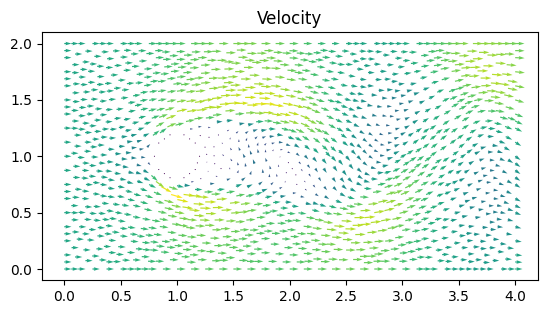

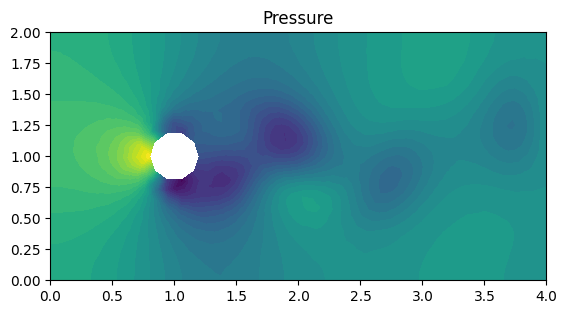

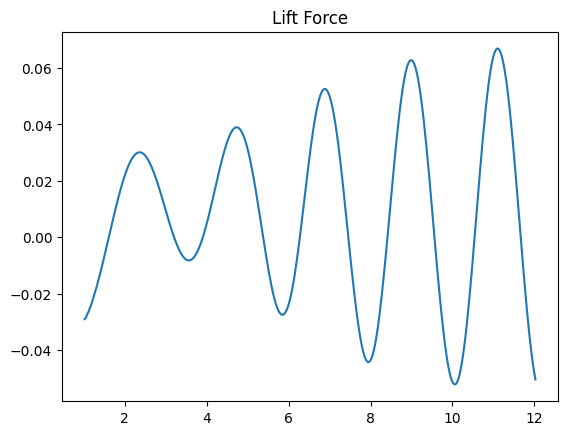

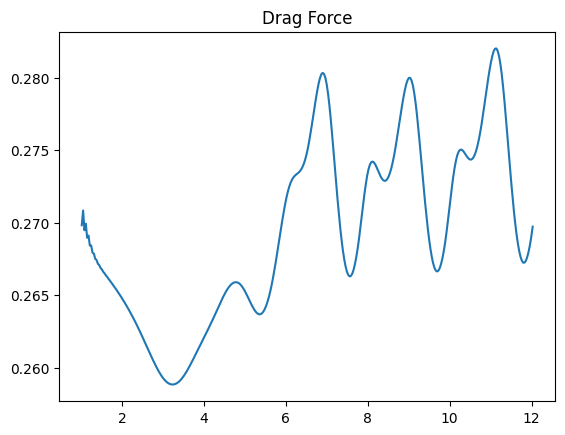

Time t = 15.014763186161508


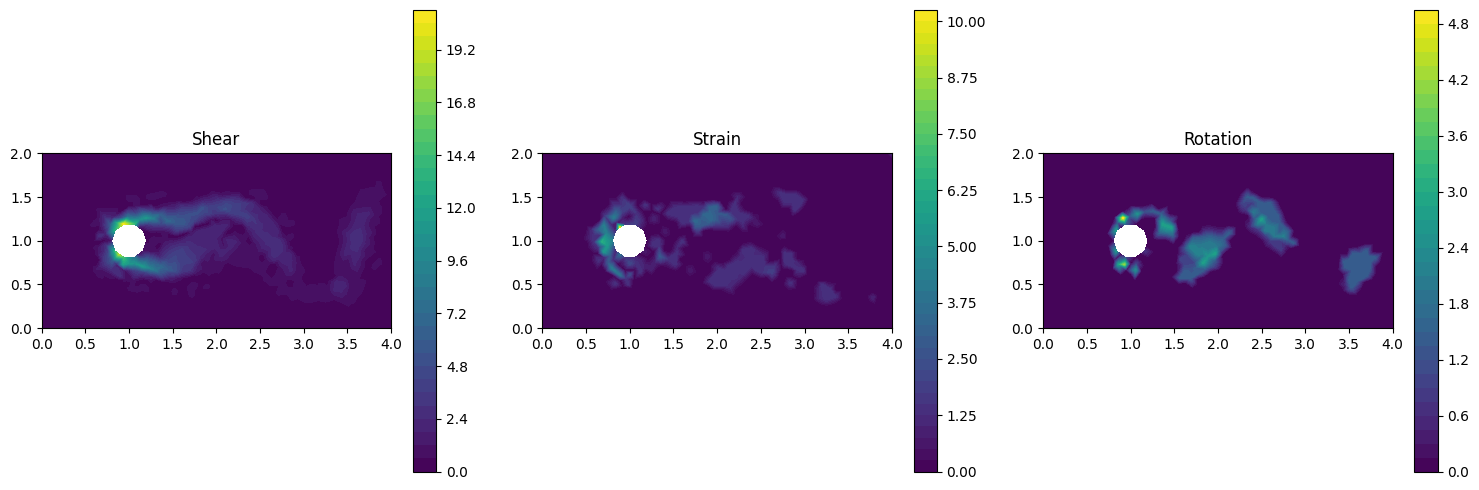

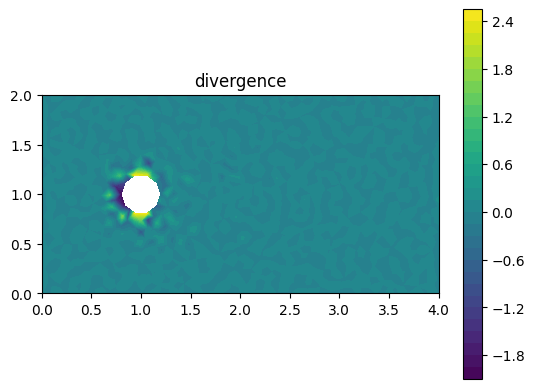

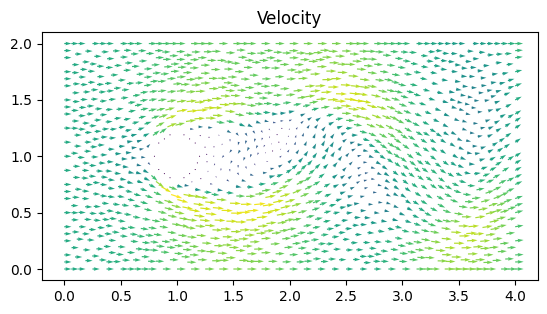

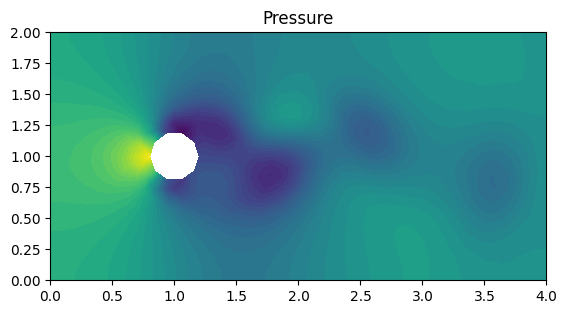

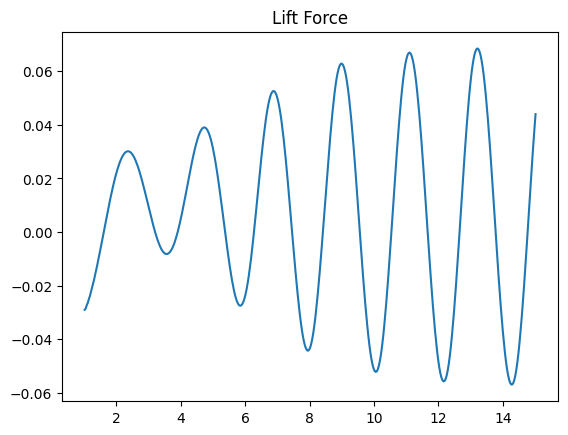

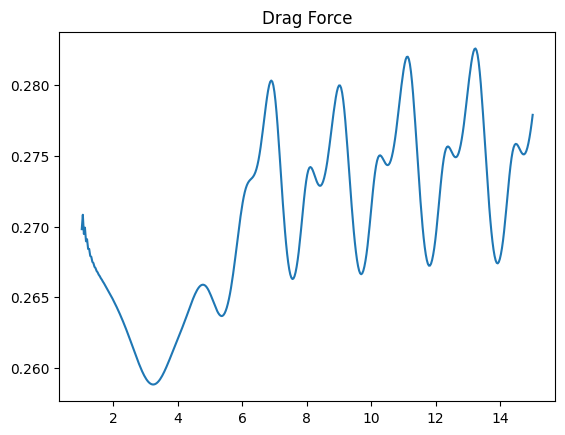

Time t = 18.00457379872328


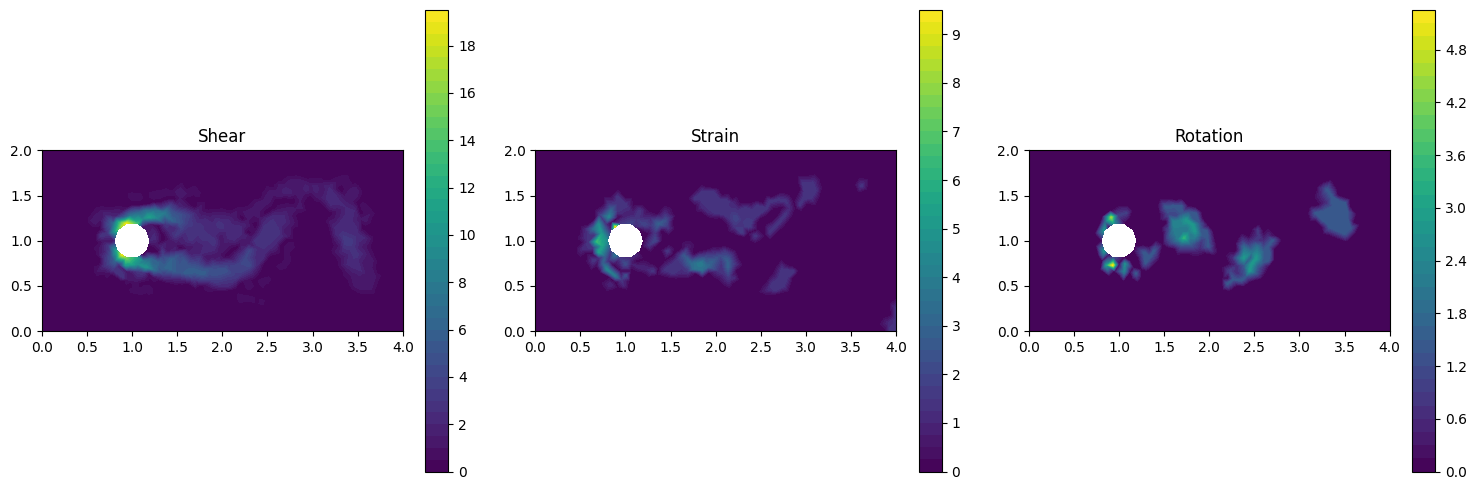

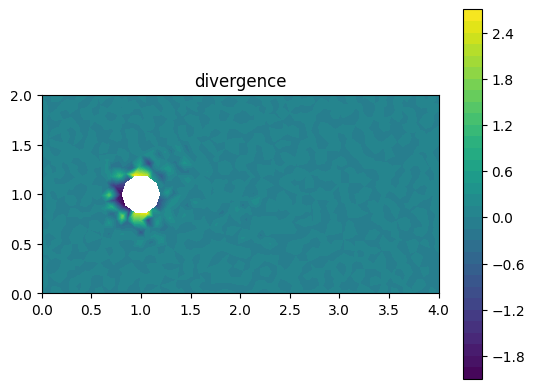

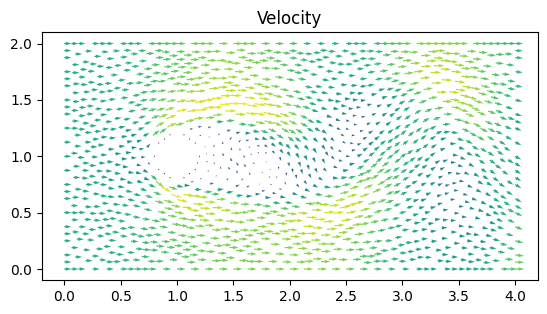

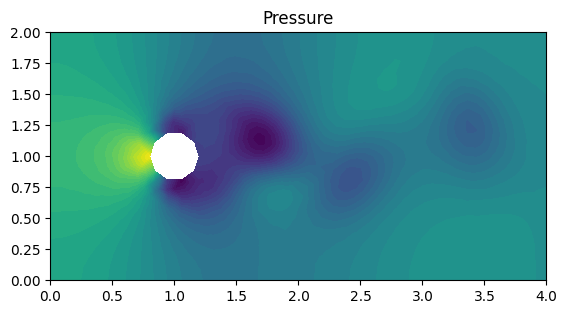

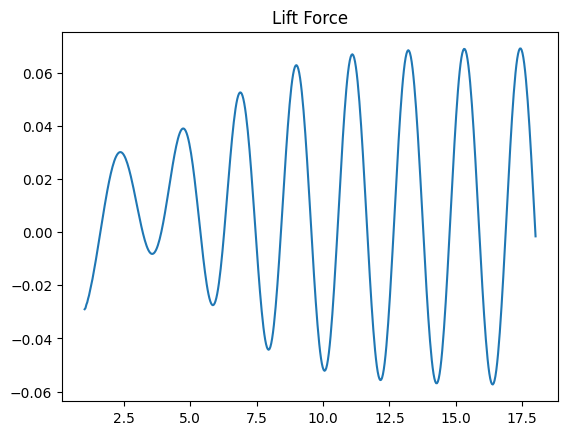

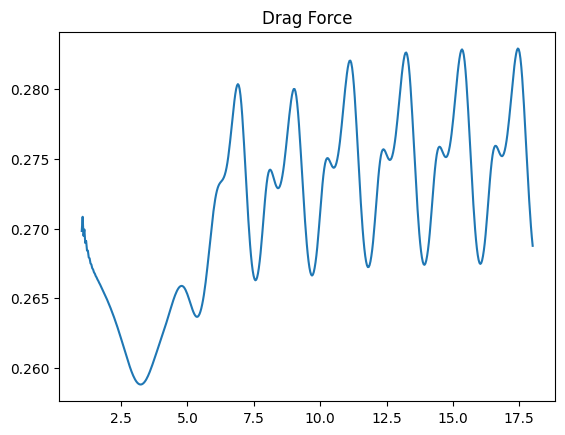

Time t = 21.027239472961604


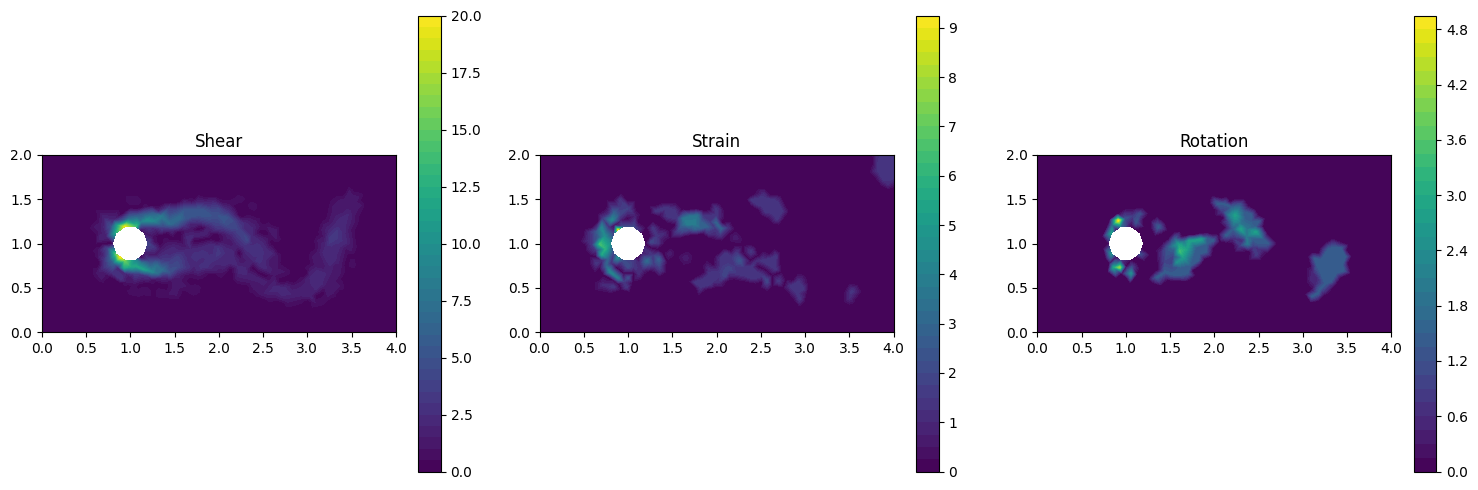

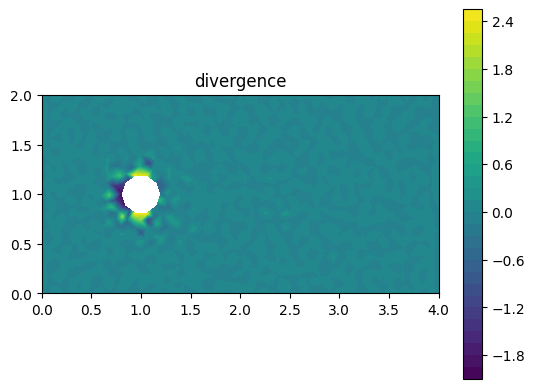

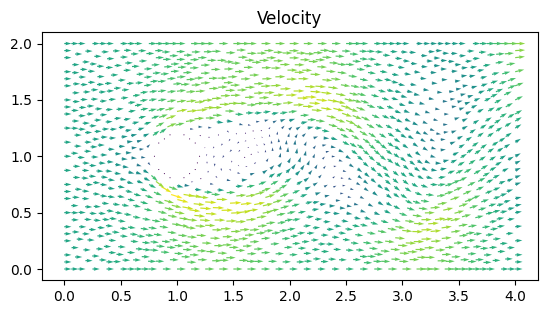

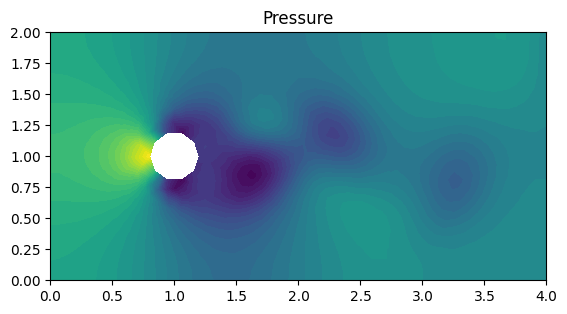

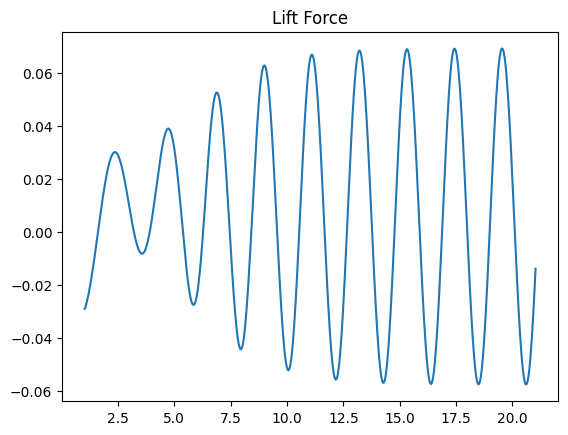

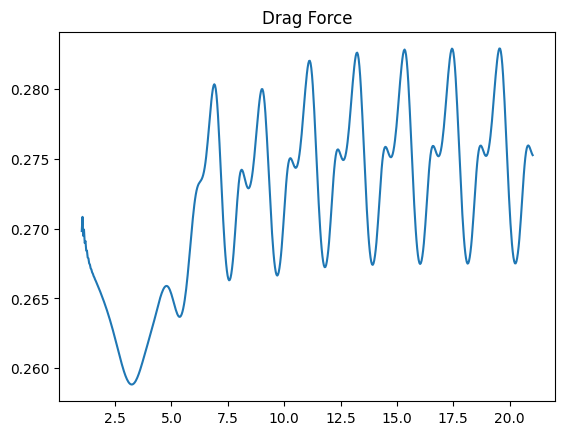

Time t = 24.017050085523426


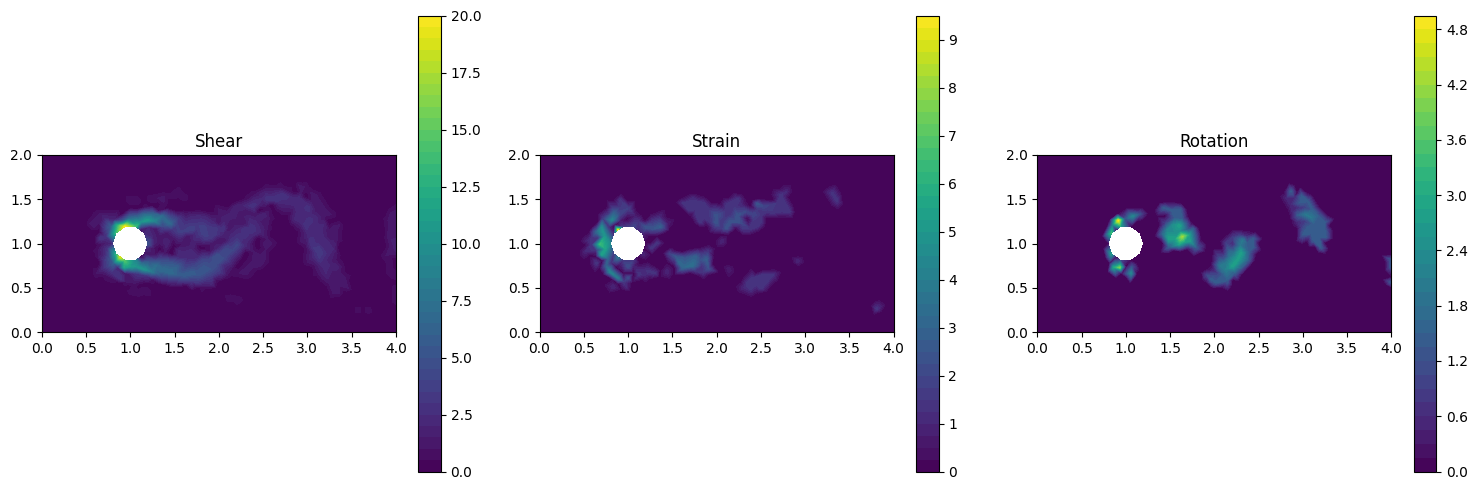

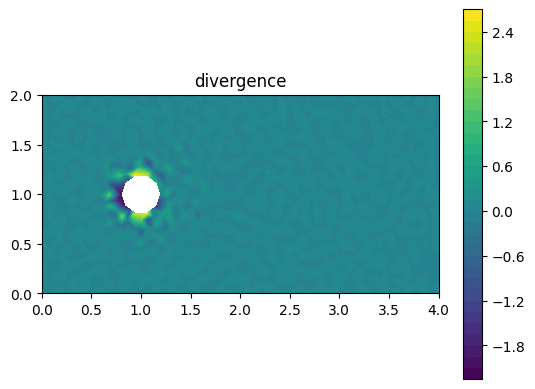

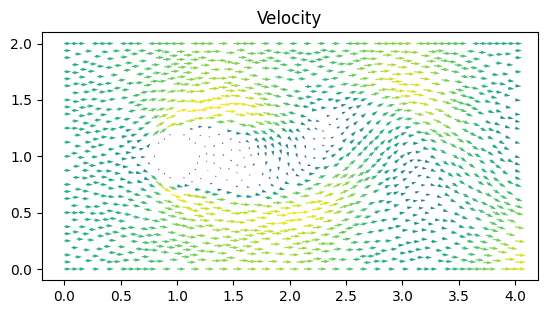

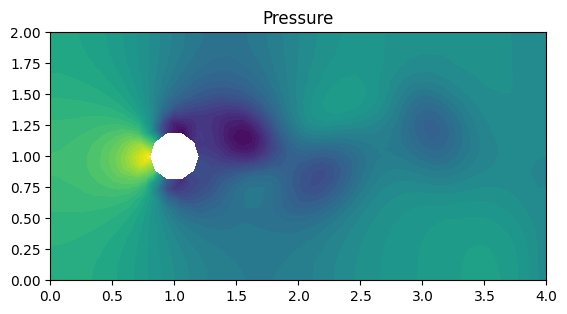

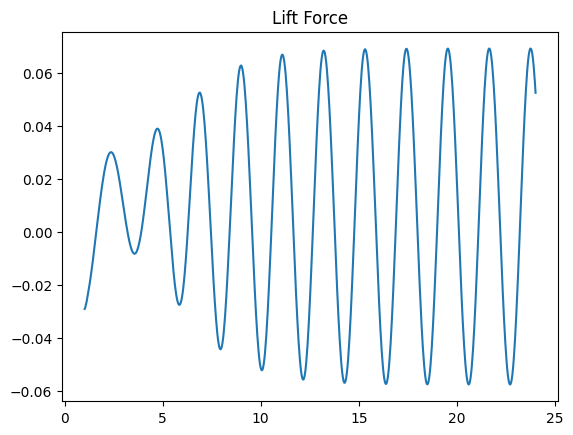

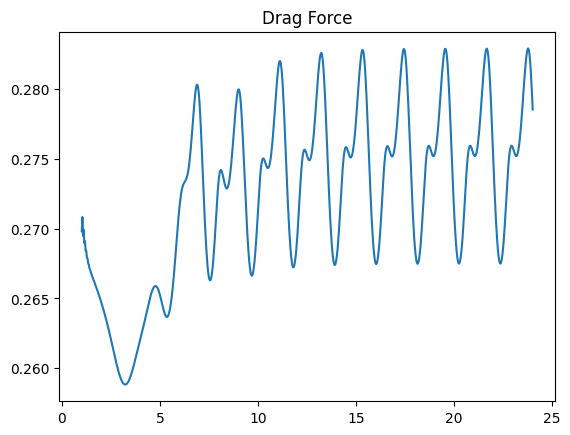

Time t = 27.006860698085248


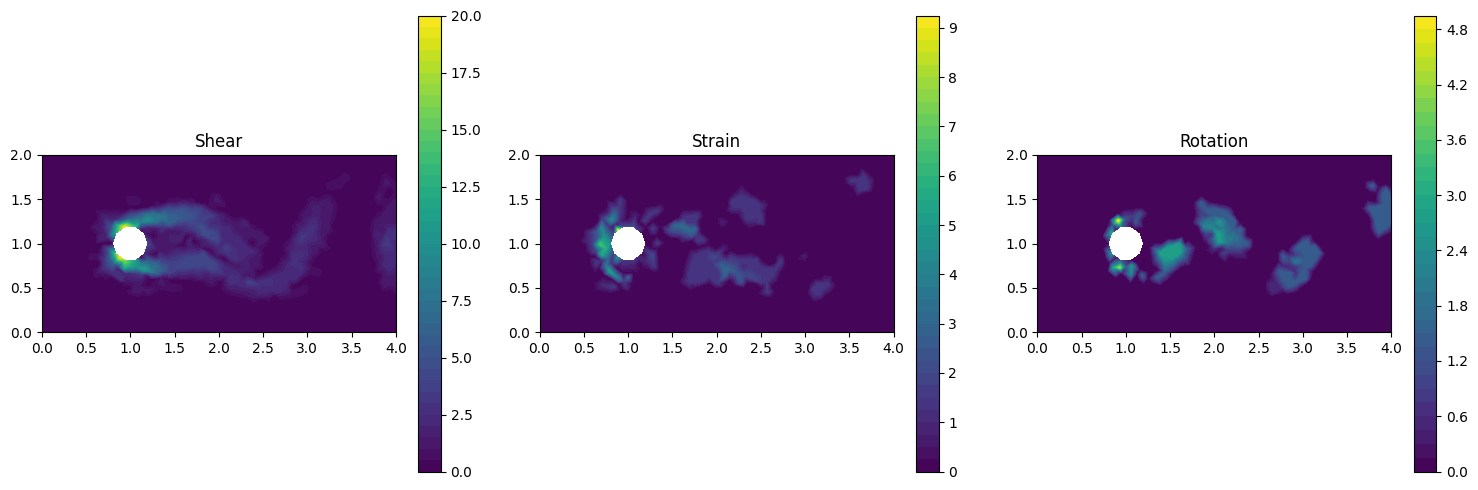

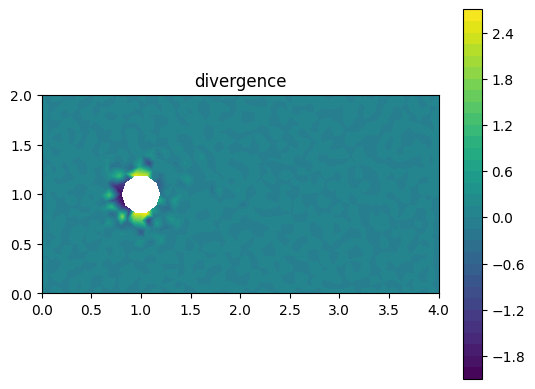

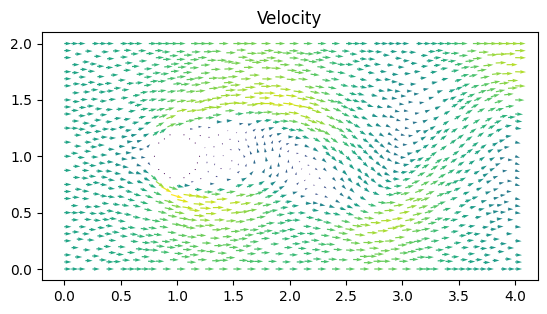

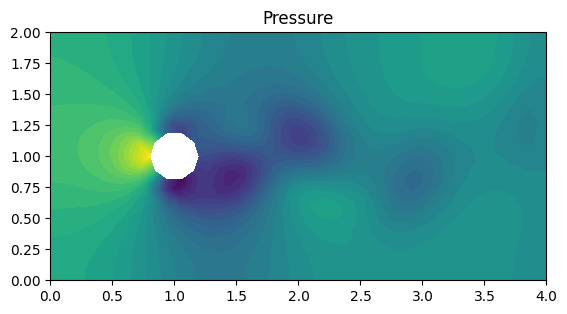

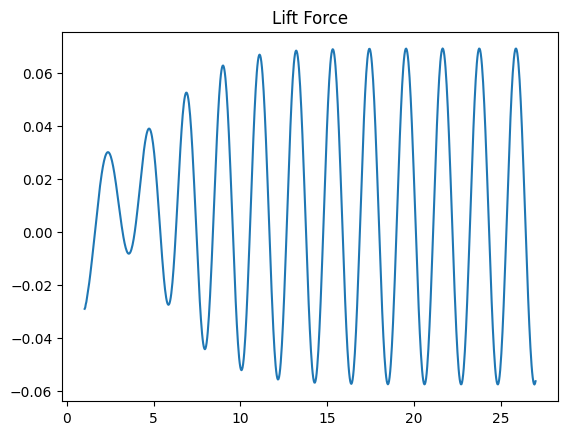

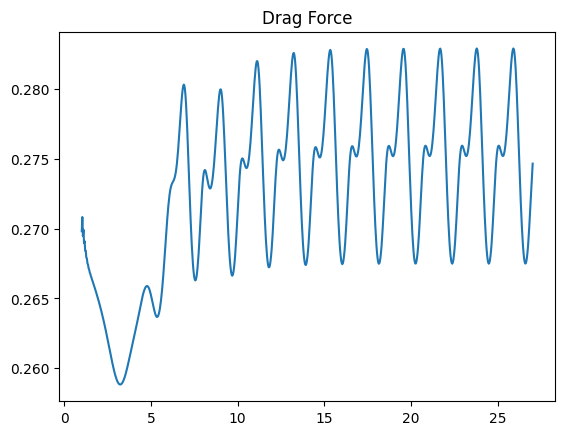

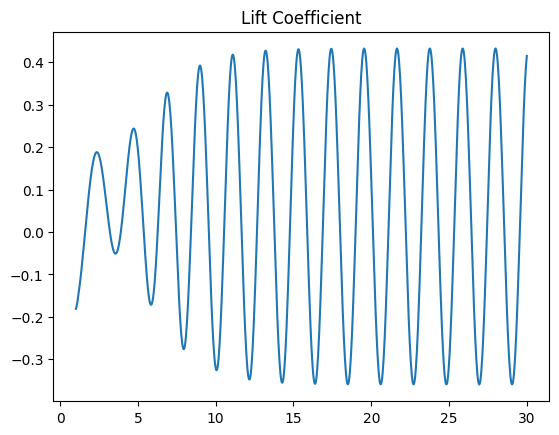

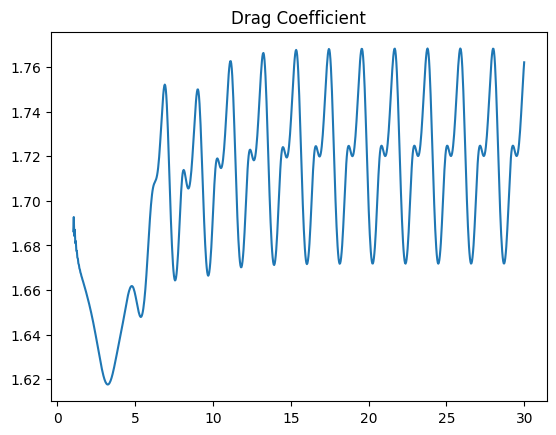

Strouhal number, St =  0.1928117405875965


In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        k += 1

    # Compute force
    FL = assemble(Force_lift)
    FD = assemble(Force_drag)
    if (t > start_sample_time):
      force_array_lift = np.append(force_array_lift, FL)
      force_array_drag = np.append(force_array_drag, FD)
      time = np.append(time, t)

    if t > para_time:
      # Save solution to file (higher frequency than plotting here for visual)
        u1.rename("velocity", "velocity")
        p1.rename("pressure", "pressure")
        file_u << u1
        file_p << p1

        para_time += T/para_freq


    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)


        # Triple decomposition
        V = TensorFunctionSpace(mesh, 'P', 1)
        grad_u1_prel = nabla_grad(u1)
        grad_u1 = project(grad_u1_prel, V)

        V2 = FunctionSpace(mesh, 'CG', 1)
        shear = Function(V2)
        elongation = Function(V2)
        rotation = Function(V2)
        dofmap = V2.dofmap()

        # Divergence
        divu = Function(V2)

        for vertex in vertices(mesh):
            point = vertex.point()
            grad_u1_point = grad_u1(point) # Evaluate the gradient tensor at the current point
            grad_u1_matrix = matrix = np.array([
                                                [grad_u1_point[0],grad_u1_point[1] ],
                                                [grad_u1_point[2], grad_u1_point[3]]
                                                                                       ])
            sh, el, rr = triple_decomposition(grad_u1_matrix)
            vertex_index = vertex.index()
            dof_index = vertex_to_dof_map(V2)[vertex_index]
            shear.vector()[dof_index] = sh
            elongation.vector()[dof_index] = el
            rotation.vector()[dof_index] = rr

            divu_vert = grad_u1_point[0] + grad_u1_point[3]
            divu.vector()[dof_index] = divu_vert

        # Plot Triple Decomposition
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        ax = plt.subplot(1, 3, 1)
        im = plot(shear, title = "Shear")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 2)
        im = plot(elongation, title = "Strain")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 3)
        im = plot(rotation, title = "Rotation")
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

        # Plot divergence
        plt.figure()
        im = plot(divu, title="divergence")
        plt.colorbar(im)

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Lift Force")
        plt.plot(time, -2*D*force_array_lift)
        plt.show()

        plt.figure()
        plt.title("Drag Force")
        plt.plot(time, -2*D*force_array_drag)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt
# Compute Lift and Drag coefficients:
U = 1       # Characteristic velo. (U) is just inflow velo, which we set here to 1
C_drag = -2*force_array_drag / (rho * U**2 * D*1)      # Drag cannot be negative, however here drag represent horizontal forces
C_lift = -2*force_array_lift / (rho * U**2 * D*1)             # Lift can be negative
# Since the forces calculated are the ones "onto the domain", the lift (and drag) forces in these calculations are the negative of this
plt.figure()
plt.title("Lift Coefficient")
plt.plot(time, C_lift)
plt.show()
plt.figure()
plt.title("Drag Coefficient")
plt.plot(time, C_drag)
plt.show()

# Calculate the Strouhal number, since we have St = fL/U, where f is a frequency, we will use FFT to find this frequency
# Since it is the frequency of vortex shredding, it should be equal to the frequency of which the lift coefficient (or Force) oscillates, at the later times
from scipy.fft import fft, fftfreq
C_lift_vec = C_lift[len(C_lift)//2:]    # Assume that after half the time, the vortex street has "stabilized"
N = len(C_lift_vec)
yf = fft(C_lift_vec - np.mean(C_lift_vec))      # Remove zero frequency content
xf = fftfreq(N, dt)[:N//2]              # possible frequencies in hertz for the signal (only positive frequencies)
dominant_freq = xf[np.argmax(np.abs(yf[:N//2]))]  # Only look at positive frequencies

St = dominant_freq * D / U
print("Strouhal number, St = ", St)


In [ ]:
# Downloads "movie" files to be watched in Paraview
# Need to "rescale to data range" for both p and u files, optional: change to viridis colormap for plots
# uncomment
!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')

results-NS/
results-NS/u000028.vtu
results-NS/p000027.vtu
results-NS/p000050.vtu
results-NS/u000053.vtu
results-NS/u000007.vtu
results-NS/u000049.vtu
results-NS/p000006.vtu
results-NS/u000054.vtu
results-NS/u000020.vtu
results-NS/u000034.vtu
results-NS/p000051.vtu
results-NS/u000042.vtu
results-NS/u000013.vtu
results-NS/u000044.vtu
results-NS/p.pvd
results-NS/p000010.vtu
results-NS/u000019.vtu
results-NS/u000008.vtu
results-NS/p000036.vtu
results-NS/u000006.vtu
results-NS/p000055.vtu
results-NS/p000040.vtu
results-NS/p000041.vtu
results-NS/p000042.vtu
results-NS/p000020.vtu
results-NS/p000008.vtu
results-NS/u000005.vtu
results-NS/u000022.vtu
results-NS/u000031.vtu
results-NS/p000054.vtu
results-NS/p000044.vtu
results-NS/p000011.vtu
results-NS/p000029.vtu
results-NS/u000051.vtu
results-NS/p000022.vtu
results-NS/u000011.vtu
results-NS/p000016.vtu
results-NS/p000018.vtu
results-NS/u000037.vtu
results-NS/p000047.vtu
results-NS/u000056.vtu
results-NS/p000028.vtu
results-NS/u000026.vtu
resul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

1. Reynolds number (Re)

  - Re = 1: As expected for very low Re, this flow remains laminar (stable) after the flow stabilizes.
    - The flow fields behave smoothly: pressure builds up in front of the obstacle and drops downstream.
    - The velocity slows down in front of the obstacle, speeds up as it passes around the sides, and then smoothly decelerates again downstream.
    - We have some shear, strain and rotation forces acting close to the cylinder.

  - Re = 10: The flow is still laminar (stable) here, after the flow stabilizes.
    - The flow fields remain smooth overall.
    - We observe an increase in the shear, strain and rotation forces.

  - Re = 100: Here we are observing turbulent (unstable) flow.
    - The flow becomes unstable, as seen in both the velocity and pressure fields. Low-pressure "bubbles" form and move downstream, initiating the formation of a von Karman vortex street.
    - Corresponding vortices appear in the velocity field.
    - The unstable turbulence can also be seen in the rotation, shear and strain plots, as such forces travel with the flow downstream from the obstacle.

  - Re = 1000: The flow becomes fully turbulent and unstable.
    - Again we can se a von Karman vortex street forming. The velocity field is unstable, and so is the pressure field.
    - The unsteady vortex street are most clearly visualized in the rotation plots, where alternating vortex patterns move downstream from the obstacle.

2. Drag and lift coefficients:
The drag and lift coefficents are calculated as:

\begin{align*}
  c_L = \frac{2F_L}{\rho u^2 S} \quad \quad c_D = \frac{2F_D}{\rho u^2 A}
\end{align*}

  where $F_L$ and $F_D$ are the lift and drag forces, $S$ is the relavent surface area and $A$ is the reference area. In this 2D setup, the reference and effective area are taken as the diameter of the cylinder, assuming depth of $1$. $\rho$ is the density of the fluid and $u$ is the relative flow speed, which in this case is the inflow velocity since it is constant.

  The Strouhal number is calculated using the frequency of the vortex shedding $f$ (in Hz), a characteristic length L, and a characteristic flow speed $u$, which again are just the diameter ($D$) and the inflow speed ($u$) respectivly.

  \begin{align*}
    S_t &= \frac{f D}{u}
  \end{align*}

  The vortex shedding frequency can be extracted from the lift force "signal" using a FFT. Since the vortex shedding frequency will match the frequency of which the lift force oscillates. This can also be assumed to be the dominant frequency content in the "signal". Hence:

  \begin{align*}
    f &= \underset{f_i}{\operatorname{arg\,max}} \left| \mathcal{F}(F_L(t)) \right| \\
  \end{align*}

  - Re = 1:
    - After initial transients (no inflow ramping), the flow stabilizes.
    - $c_{Lift} \approx 0.0378$, $c_{Drag} \approx 17.716$.
    - No vortex shedding $\rightarrow$ Strouhal number not meaningful
  - Re = 10:
    - Laminar and steady
    - $c_{L} \approx 0.053$, $c_{D} \approx 3.605$.
    - No vortex shedding
  - Re = 100:
    - Turbulent flow \rightarrow lift and drag coefficients oscillate
    - $S_t \approx 0.193 $
  - Re = 1000:
    - Fully unsteady, turbulent flow
    - $S_t \approx 0.22 $

3. Mesh resolution
  - For $h = 1/8$
  
    The mesh is too coarse to capture the higher frequencies of the turbulent flow, leading to inaccurate descriptions of $c_L$ and $c_D$
  
  - For $h = 1/16$

    The resolution improves, oscillations in lift appear, but frequency is underestimated. This underestimate is reflected in the Strouhal number, $S_t \approx 0.165$ which is a bit low for $Re = 100$

  - For $h = 1/32$

    The mesh resolves the vortex street well.
    Lift and drag coefficients oscillate as expected.
    $S_t \approx 0.193$ which is consistentwith theoretical values when a von karman vortex street is observed.